# Setup

Importing libraries, reaading the dataframe from the excel file, setting the seed for reproducibility and setting <code>ignore warnings</code>.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

df = pd.read_excel('BankClients.xlsx')

seed = 69

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Data preprocessing

The first column (index) is deleted, since it is useless for clustering.

In [2]:
df.drop(labels = 'ID', axis = 1, inplace = True)

The original dataframe is splitted into one containing the numerical features and a second one containing the categorical features.

In [3]:
df_num = df[['Age', 'Income', 'Wealth', 'Debt', 'FinEdu', 'ESG', 'Digital', 'BankFriend', 'LifeStyle', 'Luxury', 'Saving', 'FamilySize']]
df_cat = df[['Gender', 'Job', 'Area', 'CitySize', 'Investments']]

Since the dataframe contains both categorical and numerical features, using classical distance metrics (e.g. Euclidean distance) would not be the best option. A mixed distance should be used, which takes into account the <code>Hamming</code> distance measure for categorical features and the <code>L1</code> distance mesure for numerical features. To use the <code>Hamming</code> distance measure, a one-hot encoding is needed. 

The <code>pandas</code> function <code>get_dummies</code> is used to generate one-hot encoded features, so that each column (i.e. feature) in the initial dataframe is converted into <code>n</code> columns, where <code>n</code> is the number of possible values of that feature. The final dataframe is constructed as the concatenation of the new one-hot encoded features with the numerical ones. 

In [4]:
# creating an empty dataframe for dummy variables
df_dummy = pd.DataFrame()

# for each column of the dataframe containing the categorical features, the respective one hot-encoding dataframe (n columns)
# is created and concatenated to the one containing all of them. Columns need to be renamed after the encoding to prevent
# them to get the same name.

for columns in df_cat.columns:
    df_temp = pd.get_dummies(df_cat[columns])
    df_temp.columns = [columns + str(x) for x in df_temp.columns]
    df_dummy = pd.concat([df_dummy, df_temp], axis = 1)

df = pd.concat([df_dummy, df_num], axis = 1)

In order to facilitate the clustering, <code>MinMax</code> scaling is applied to the data (feature-wise).

In [5]:
for c in df.columns:
    df[c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min())

A random subsample of data is selected to shorten the computation time. <code>frac = 0.2</code> reduces the original $5000$ samples to $1000$, which should still be enough to perform clustering effectively. 

The dataframe is converted into an array.

In [6]:
data = df.sample(frac = 0.2, random_state = seed).to_numpy()

# Data exploration

The function <code>mixed_distance</code> to compute distance is defined.

<code>hamming</code> distance metric is used for categorical values and $L1$ (<code>cityblock</code>) is used for numerical values. The sum is weighted by the number of features **before** one-hot encoding, otherwise dummy variables would be considered.

In [7]:
from scipy.spatial.distance import cdist

def mixed_distance(A, B):
    nFeatures = 28      # total number of features (i.e. total number of columns of the array)
    nOneHot = 16        # number of one-hot encoded features (columns of the array with possible values 0/1)
    nCategorical = 5    # number of categorical features before one-hot encoding, used in the weighted sum to evaluate the distance

    # reshaping is needed in order for the function to work
    A = A.reshape(1,-1)
    B = B.reshape(1,-1)

    # computing the hamming distance for one-hot columns and cityblock (L1) distance for numerical columns
    dCategorical = cdist(A[:, :nOneHot], B[:, :nOneHot], 'hamming')
    dNumeric = cdist(A[:, nOneHot:], B[:, nOneHot:], 'cityblock')

    # computing the weight associated to categorical features (number of categorical features divided by total number of features)
    wCategorical = float(nCategorical) / (float(nFeatures))

    # computing the distance as the weighted sum of hamming and L1 distances
    distance = wCategorical * dCategorical + (1 - wCategorical) * dNumeric
    return distance

## t-SNE
t-distributed stochastic neighbor embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.

There are two main hyperparameters for t-SNE (in addition to the dimensionality of the final representation), which are <code>perplexity</code> and <code>learning_rate</code>.

<code>perplexity</code> defines the balance between local and global aspects of the data. The parameter is, in a sense, a guess about the number of close neighbors each point has. Usual values are in the range $\left[ 5, 50\right]$.

<code>learning_rate</code> defines the step size at each iteration. If the <code>learning_rate</code> is too high, data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the <code>learning_rate</code> is too low, most points may look compressed in a dense cloud with few outliers. Usual values are in the range $\left[ 10, 1000\right]$.

Initially the <code>learning_rate</code> is set to the default value $\left( 200\right)$, and t-SNE is applied with different <code>perplexity</code> values. Then we fix the <code>perplexity</code> to the value which yielded the best results (in terms of effectively separating data) and apply tSNE with different <code>learning_rate</code> values.

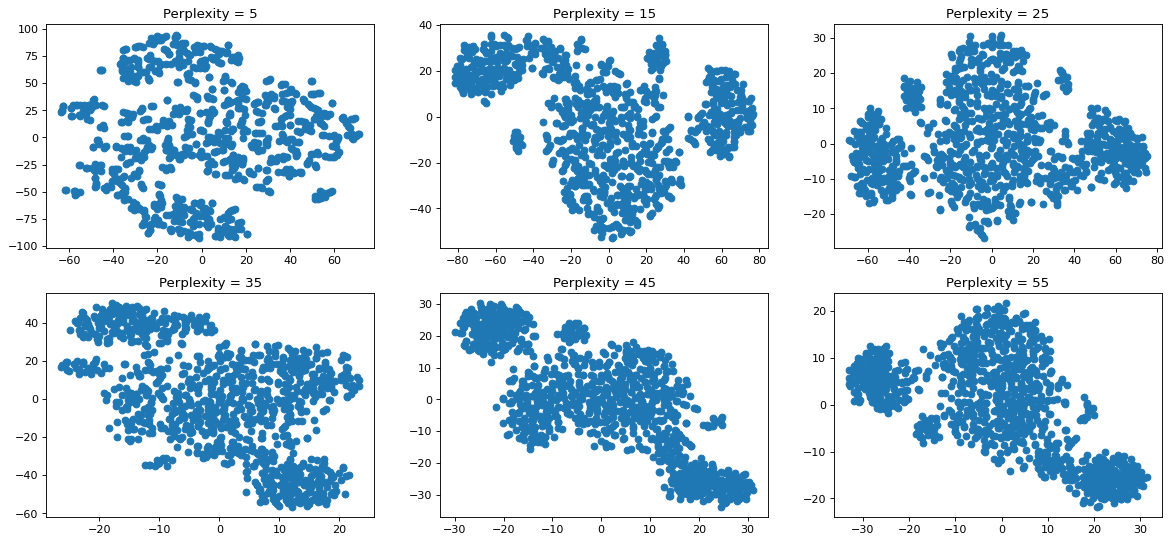

In [13]:
from sklearn.manifold import TSNE

# usual values for perplexity are in the range (5, 50) so we define a range (5, 55) with step size = 10
initial_perplexity = 5
final_perplexity = 55
step = 10
perplexity_vector = np.arange(initial_perplexity, final_perplexity + step, step)

learning_rate = 200   # default value
dimensions = 2        # output dimensionality

# defining rows and columns of the subplots, then defining the matplotlib object to contain multiple plots
row = 0
column = 0
max_rows = 2
max_columns = 3
fig, axes = plt.subplots(max_rows, max_columns, figsize=(18,8), dpi=80)

# for each perplexity value we apply t-sne and plot the results
for perplexity in perplexity_vector:
  tsne = TSNE(n_components=dimensions,
              perplexity=perplexity,
              learning_rate=learning_rate,
              metric=mixed_distance,        # the metric used is the custom mixed_distance
              random_state=seed)
  
  # using fit_transform to apply the transformation on the data and store the new representation in X_tsne
  X_tsne = tsne.fit_transform(data)

  # defining the subplot to plot data on
  ax = axes[row][column]

  # plotting the data in a scatterplot
  ax.scatter(X_tsne[:, 0], X_tsne[:, 1])
  ax.set_title(f'Perplexity = {perplexity}')

  # updating column and row values
  column = column + 1
  if column % max_columns == 0:
    column = 0
    row = row + 1 

Now <code>perplexity</code> is fixed and different values of <code>learning_rate</code> are considered.

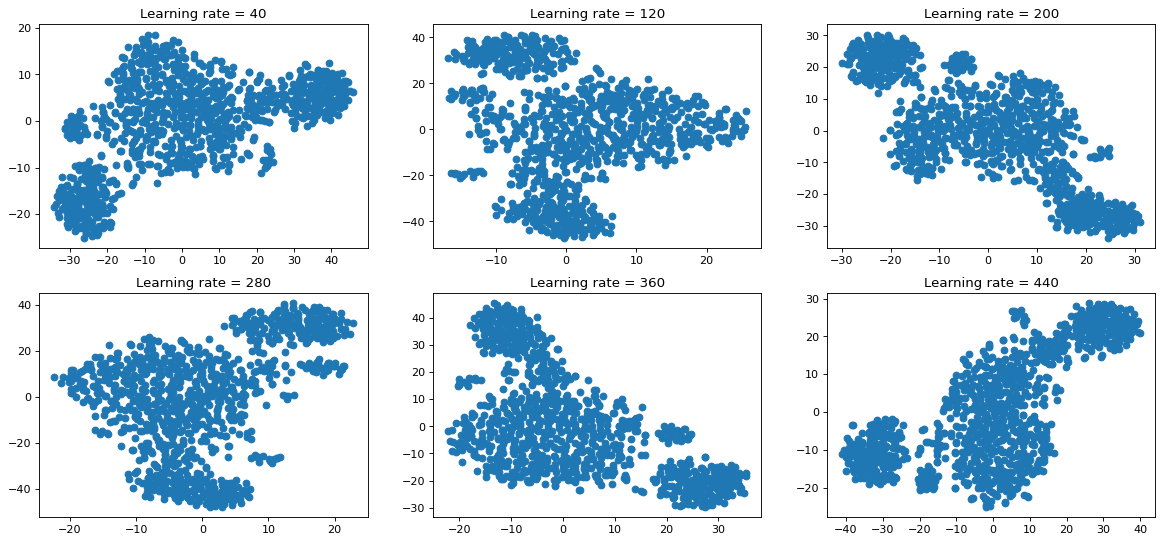

In [20]:
# setting learning_rate to vary between 80 and 520 with step size of 40
initial_learning_rate = 40
final_learning_rate = 440
step = 80
learning_rate_vector = np.arange(initial_learning_rate, final_learning_rate + step, step)

perplexity = 45   # 'best' value from past cell
dimensions = 2

row = 0
column = 0
max_rows = 2
max_columns = 3
fig, axes = plt.subplots(max_rows, max_columns, figsize=(18,8), dpi=80)

for learning_rate in learning_rate_vector:
  tsne = TSNE(n_components=dimensions,
              perplexity=perplexity,
              learning_rate=learning_rate,
              metric=mixed_distance,
              random_state=seed)
  
  X_tsne = tsne.fit_transform(data)

  ax = axes[row][column]

  ax.scatter(X_tsne[:, 0], X_tsne[:, 1])
  ax.set_title(f'Learning rate = {learning_rate}')
  
  column = column + 1
  if column % 3 == 0:
    column = 0
    row = row + 1 

## PCA
Principal component analysis (PCA) is a popular technique for analyzing large datasets containing a high number of dimensions/features per observation, increasing the interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data.

Here Principal Component Analysis is applied to numerical features in order to evaluate if feature reduction could be effective. Feature variance (in decreasing order) is computed before and after PCA, in addition to the 'cumulative variance'. 'Cumulative variance' of feature <code>i</code> is intended as the sum of variances from feature $1$ to feature <code>i</code>. 

Values are normalized by the sum of feature variances (trace of covariance matrix).

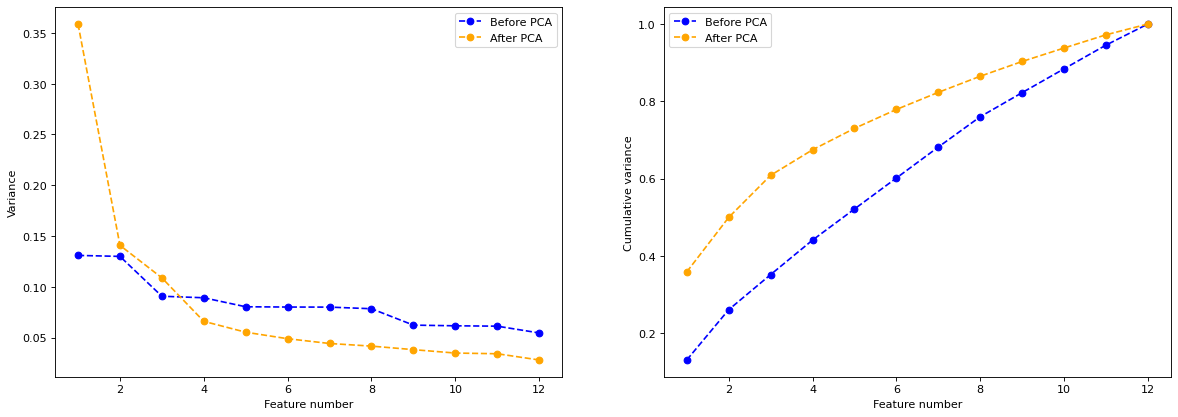

In [12]:
from sklearn.decomposition import PCA

# defining the numerical portion of data array (from 17th feature on, so starting from index 16)
num_data = data[:, 16:]

# calculating covariance matrix, variance vector and cumulative sum vector of data before applying PCA
# the values are normalized in order to have the sum of feature variances equal to one
cov = np.cov(num_data.T) / np.trace(np.cov(num_data.T))
var = np.flip(np.sort(np.diag(cov)))        # np.flip is used since np.sort sorts the vector in increasing order
cumulative = np.empty(var.shape)
for i in range(var.shape[0]):
    cumulative[i] = sum(var[:i+1])

# applying PCA and storing transformed data in pca_data
pca = PCA(n_components = num_data.shape[1], random_state = seed)
pca.fit(num_data)
pca_data = pca.transform(num_data)

# calculating covariance matrix, variance vector and cumulative sum vector of data after applying PCA
pca_cov = np.cov(pca_data.T) / np.trace(np.cov(num_data.T))
pca_var = np.flip(np.sort(np.diag(pca_cov)))
pca_cumulative = np.empty(pca_var.shape)
for i in range(pca_var.shape[0]):
    pca_cumulative[i] = sum(pca_var[:i+1])

# creating a vector containing the indexes of the numerical features used to plot PCA results
x = np.arange(1, var.shape[0] + 1)

fig, axes = plt.subplots(1, 2, figsize=(18,6), dpi=80)

# plotting the variances before and after PCA
ax = axes[0]
ax.plot(x, var, 'o--', color = 'blue', label = 'Before PCA')
ax.plot(x, pca_var, 'o--', color = 'orange', label = 'After PCA')
ax.set_xlabel('Feature number')
ax.set_ylabel('Variance')
ax.legend()

# plotting the cumulative variances before and after PCA
ax = axes[1]
ax.plot(x, cumulative, 'o--', color = 'blue', label = 'Before PCA')
ax.plot(x, pca_cumulative, 'o--', color = 'orange', label = 'After PCA')
ax.set_xlabel('Feature number')
ax.set_ylabel('Cumulative variance')
ax.legend()

plt.show()

# Clustering

Several clustering techniques are tried out: k-medoids, DBSCAN, OPTICS and Gaussian Mixture Model. To evaluate the performance of these algorithms, three different scores are used:

- The *silhouette score* is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score is calculated using the mean intra-cluster distance (<code>a</code>) and the mean nearest-cluster distance (<code>b</code>) for each sample. The silhouette score for a sample is <code>(b - a) / max(a, b)</code>. To clarify, <code>b</code> is the distance between a sample and the nearest cluster that the sample is not a part of. The best value is $1$ and the worst value is $-1$. Values near $0$ indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

- The *Calinski-Harabasz* (CH) *score*, also known as Variance ratio criterion, is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Cohesion is estimated based on the distances from the data points in a cluster to its cluster centroid and separation is based on the distance of the cluster centroids from the global centroid. Higher value of CH score means the clusters are dense and well separated, although there is no 'acceptable' cut-off value. The value to be chosen is the one that gives a peak, or at least an abrupt elbow, on the line plot of CH indices. On the other hand, if the line is smooth (horizontal or ascending or descending) then there is no such reason to prefer one solution over others.

- The *Davies-Boulding* (DB) *score* is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.The minimum score is zero, with lower values indicating better clustering.

These scores are used in model selection to choose the optimum values for the hyperparameters of each clustering technique. Results are then plotted in 2D t-SNE representation.

## k-medoids clustering 

k-medoids clustering technique attempts to minimize the distance between points labeled to be in a cluster and a point designated as the center of that cluster, called medoid. The algorithm starts by randomly selecting <code>k</code> medoids from the dataset, where <code>k</code> is the number of clusters desired. Then, each data point is assigned to the nearest medoid based on a distance metric (<code>mixed_distance</code> in this case). The algorithm then iteratively updates the medoids by trying to minimize the sum of distances between each data point and its assigned medoid.

<code>k</code> values between <code>k_min = 3</code> and <code>k_max = 10</code> are tried out. The scores are computed and stored for each <code>k</code> value.

In [17]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

k_min = 3
k_max = 10

# defining the vector containing the possible values of k
k_vector = np.arange(k_min, k_max + 1, 1)

# defining the empty vectors of the scores
silhouette = np.empty(k_vector.shape)
ch_score = np.empty(k_vector.shape)
db_score = np.empty(k_vector.shape)

# for each k value, run the k-medoids algorithm and store the values of the scores
for k in k_vector:
    kmedoids = KMedoids(n_clusters = k, metric = mixed_distance, random_state = seed).fit(data)
    silhouette[k - k_min] = silhouette_score(data, kmedoids.labels_, metric = mixed_distance, random_state = seed)
    ch_score[k - k_min] = calinski_harabasz_score(data, kmedoids.labels_)
    db_score[k - k_min] = davies_bouldin_score(data, kmedoids.labels_)

Plotting silhouette, Calinski-Harabasz and Davies-Bouldin metrics as a function of <code>k</code>

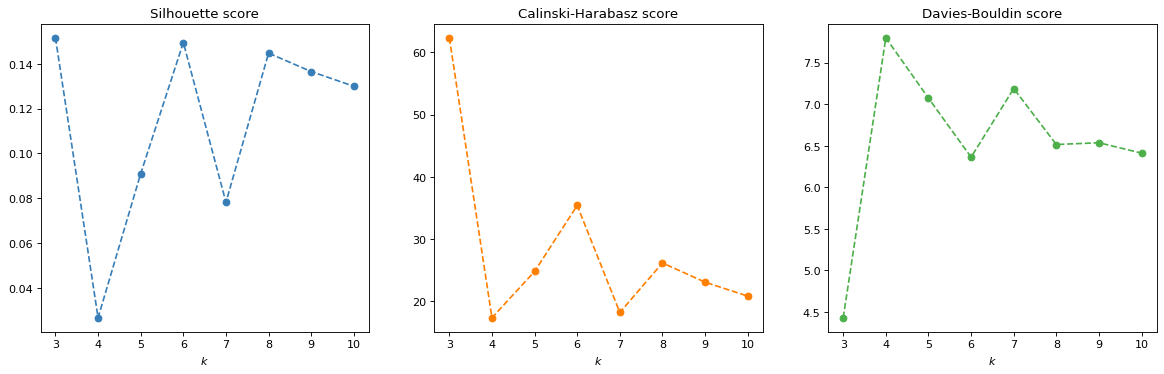

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18,5), dpi=80)
ax = axes[0]
ax.plot(k_vector, silhouette, 'o--', color = '#377eb8')
ax.set_xlabel('$k$')
ax.set_title('Silhouette score')

ax = axes[1]
ax.plot(k_vector, ch_score, 'o--', color = '#ff7f00')
ax.set_xlabel('$k$')
ax.set_title('Calinski-Harabasz score')

ax = axes[2]
ax.plot(k_vector, db_score, 'o--', color = '#4daf4a')
ax.set_xlabel('$k$')
ax.set_title('Davies-Bouldin score')

plt.show()

<code>k = 3</code> and <code>k = 6</code> are selected as the best <code>k</code> for k-medoids according to the above scores:

- <code>k = 3</code> shows the best metrics, but three clusters are not many;
- <code>k = 6</code> shows worse results with respect to <code>k = 6</code> but the results may be more interpretable and useful.

Results are plotted in t-SNE representation with <code>perplexity = 45</code> and <code>learning_rate = 200</code>.

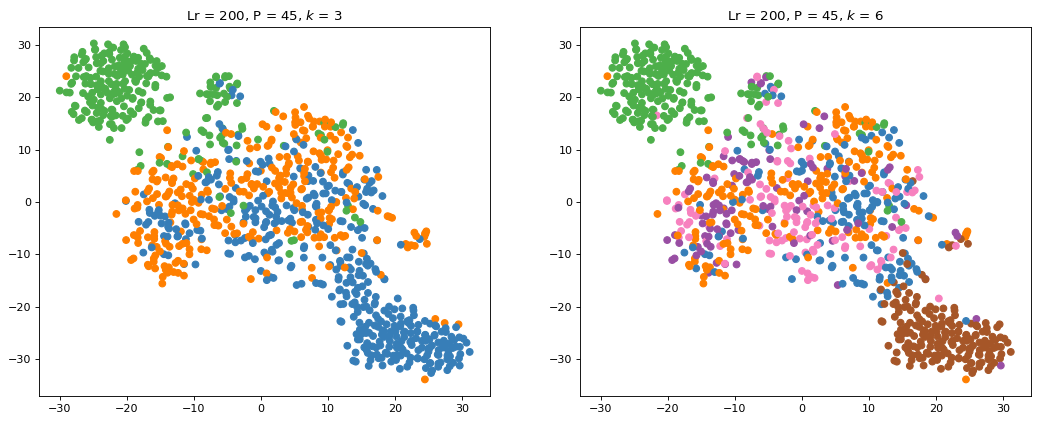

In [21]:
# running k-medoids for k = 3 and k = 6
k_values = [3, 6]

# defining the values for learning rate and perplexity that are going to be used for t-SNE
perplexity = 45
learning_rate = 200
dimensions = 2

# running t-SNE to have a 2D data representation
tsne = TSNE(n_components=dimensions,
            perplexity=perplexity,
            learning_rate=learning_rate,
            metric=mixed_distance,
            random_state=seed)

X_tsne = tsne.fit_transform(data)

fig, axes = plt.subplots(1, 2, figsize=(16,6), dpi=80)
ax_count = 0

for k in k_values:

   kmedoids = KMedoids(n_clusters = k, metric = mixed_distance, random_state = seed).fit(data)

   # defining the 'colors' list that is going to be used to assign a different color to each data point in the plot
   color_list = ['#377eb8', '#ff7f00', '#4daf4a', "#f781bf", "#a65628", "#984ea3"]
   colors = []
   for i in kmedoids.labels_:
      colors.append(color_list[i])

   # plotting the clusters in t-SNE representation on a subplot for each k
   ax = axes[ax_count]
   ax.scatter(X_tsne[:, 0], X_tsne[:, 1], color=colors)
   ax.set_title(f'Lr = {learning_rate}, P = {perplexity}, $k$ = {k}')

   # updating the counter for the subplot
   ax_count = ax_count + 1

## DBSCAN

Density-based spatial clustering of applications with noise (DBSCAN) is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).

A fundamental hyperparameter in DBSCAN clustering is <code>eps</code>, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. To have an idea of the order of magnitude of this value, the average distance between data points using <code>mixed_metric</code> is computed.

In [16]:
# average distance is computed as the sum of distances between all samples divided by the number of all the distances
# sum of all distances is initialized to zero (float is used to not lose decimals during the computation of avg_distance)
distances_sum = 0.0

# the total number of distances of between samples (n = data.shape[0] in this case) is n(n+1)/2
distances_number = (data.shape[0]) * (data.shape[0] + 1.0) / 2.0

# updating the sum of distances for each couple of points
for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        distances_sum = distances_sum + mixed_distance(data[i], data[j])

avg_distance = distances_sum / distances_number
print(avg_distance)

[[1.19837354]]


Since this algorithm is not performing too well on the data, filtering was applied in order to remove inconsistent results. <code>[Continue here the discussion on the filtering]</code>

In [11]:
from math import floor
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

initial_eps = 0.4
final_eps = 0.6
step_eps = 0.1

initial_min_samples = 3
final_min_samples = 7
step_min_samples = 2

eps_vector = np.arange(initial_eps, final_eps + step_eps, step_eps)
min_samples_vector = np.arange(initial_min_samples, final_min_samples + step_min_samples, step_min_samples)

silhouette_list = []
db_list = []
ch_list = []
outliers_number_list = []
eps_list = []
min_samples_list = []
outliers_threshold = 95
dbscan_labels = np.empty((eps_vector.shape[0] * min_samples_vector.shape[0], data.shape[0]))
count = 0

for eps in eps_vector:
    for min_samples in min_samples_vector:
        temp_labels = DBSCAN(eps=eps, min_samples=min_samples, metric=mixed_distance).fit_predict(data)

        is_outlier = temp_labels == -1
        is_not_outlier = temp_labels != -1
        unique_labels = np.unique(temp_labels[is_not_outlier]).shape[0]
        # not good labels = only one class or more than ten classes
        is_not_good_labels = (unique_labels < 2) or (unique_labels > 10)
        outliers_percentage = floor(float(temp_labels[is_outlier].shape[0]) / float(data.shape[0]) * 100.0)

        if is_not_good_labels or (outliers_percentage > outliers_threshold):
            continue

        eps_list.append(eps)
        min_samples_list.append(min_samples)
        outliers_number_list.append(outliers_percentage)
        dbscan_labels[count, :] = np.copy(temp_labels)
        count = count + 1

        silhouette_list.append(silhouette_score(data[is_not_outlier], 
                                                temp_labels[is_not_outlier], 
                                                metric = mixed_distance, 
                                                random_state = seed))
        
        db_list.append(davies_bouldin_score(data[is_not_outlier], 
                                            temp_labels[is_not_outlier]))
        
        ch_list.append(calinski_harabasz_score(data[is_not_outlier], 
                                               temp_labels[is_not_outlier]))

In [13]:
print(eps_list)
print(min_samples_list)

[0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6]
[4, 5, 6, 7, 4, 5, 6, 7, 3]


Plotting silhouette as a function of <code>eps</code> and <code>min_samples</code> hyperparameters, showing also the percentage of outliers

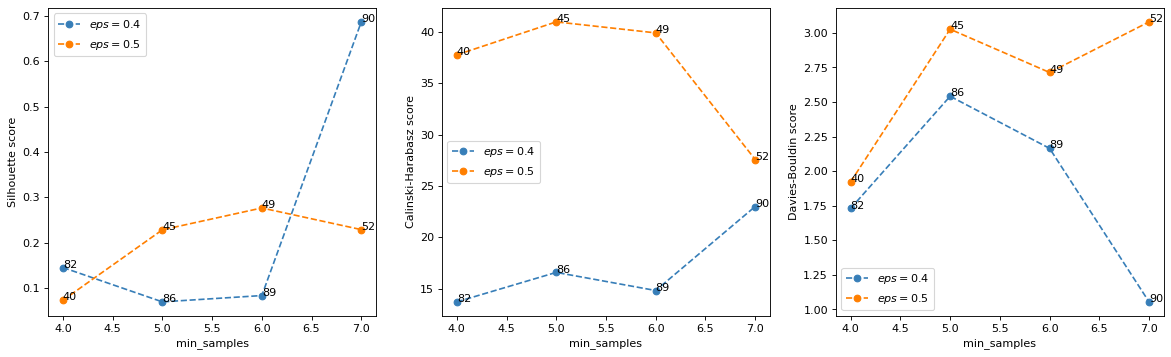

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18,5), dpi=80)
ax = axes[0]
ax.plot(min_samples_list[:4], silhouette_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], silhouette_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Silhouette score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], silhouette_list[i]))
ax.legend()

ax = axes[1]
ax.plot(min_samples_list[:4], ch_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], ch_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Calinski-Harabasz score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], ch_list[i]))
ax.legend()

ax = axes[2]
ax.plot(min_samples_list[:4], db_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], db_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Davies-Bouldin score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], db_list[i]))
ax.legend()

plt.show()

Plotting DBSCAN results in tSNE representation

In [17]:
labels = DBSCAN(eps=0.5, min_samples=5, metric=mixed_distance).fit_predict(data)
is_not_outlier = labels != -1
unique_labels = np.unique(labels[is_not_outlier]).shape[0]
print(unique_labels)

Text(0.5, 1.0, 'Lr = 480 - P = 35')

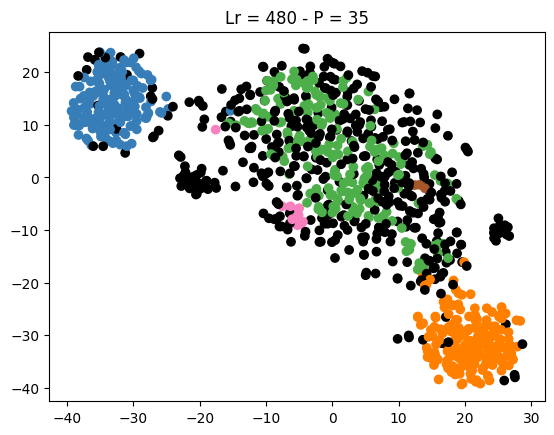

In [24]:
from sklearn.manifold import TSNE

color_list = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', 'black']
colors = []
for i in labels:
   colors.append(color_list[i])

tsne = TSNE(n_components=2,
            perplexity=35,
            learning_rate=480,
            metric=mixed_distance,
            random_state=seed)
X_tsne = tsne.fit_transform(data)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], color=colors)
plt.title(f'Lr = 480 - P = 35')
plt.show()

## OPTICS

<code>[Insert optics description]</code>

In [25]:
from math import floor
from sklearn.cluster import OPTICS

initial_eps = 0.4
final_eps = 0.6
step_eps = 0.1

initial_min_samples = 4
final_min_samples = 7
step_min_samples = 1

eps_vector = np.arange(initial_eps, final_eps + step_eps, step_eps)
min_samples_vector = np.arange(initial_min_samples, final_min_samples + step_min_samples, step_min_samples)

silhouette_list = []
db_list = []
ch_list = []
outliers_number_list = []
eps_list = []
min_samples_list = []
outliers_threshold = 95
optics_labels = np.empty((eps_vector.shape[0] * min_samples_vector.shape[0], data.shape[0]))
count = 0

for eps in eps_vector:
    for min_samples in min_samples_vector:
        temp_labels = OPTICS(eps=eps, min_samples=min_samples, metric=mixed_distance).fit_predict(data)

        is_outlier = temp_labels == -1
        is_not_outlier = temp_labels != -1
        unique_labels = np.unique(temp_labels[is_not_outlier]).shape[0]
        # not good labels = only one class or more than ten classes
        is_not_good_labels = (unique_labels < 2) or (unique_labels > 10)
        outliers_percentage = floor(float(temp_labels[is_outlier].shape[0]) / float(data.shape[0]) * 100.0)

        if is_not_good_labels or (outliers_percentage > outliers_threshold):
            continue

        eps_list.append(eps)
        min_samples_list.append(min_samples)
        outliers_number_list.append(outliers_percentage)
        optics_labels[count, :] = np.copy(temp_labels)
        count = count + 1

        silhouette_list.append(silhouette_score(data[is_not_outlier], 
                                                temp_labels[is_not_outlier], 
                                                metric = mixed_distance, 
                                                random_state = seed))
        
        db_list.append(davies_bouldin_score(data[is_not_outlier], 
                                            temp_labels[is_not_outlier]))
        
        ch_list.append(calinski_harabasz_score(data[is_not_outlier], 
                                               temp_labels[is_not_outlier]))

In [26]:
print(eps_list)
print(min_samples_list)

[]
[]


In [ ]:
""" fig, axes = plt.subplots(1, 3, figsize=(18,5), dpi=80)
ax = axes[0]
ax.plot(min_samples_list[:4], silhouette_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], silhouette_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Silhouette score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], silhouette_list[i]))
ax.legend()

ax = axes[1]
ax.plot(min_samples_list[:4], ch_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], ch_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Calinski-Harabasz score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], ch_list[i]))
ax.legend()

ax = axes[2]
ax.plot(min_samples_list[:4], db_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], db_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Davies-Bouldin score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], db_list[i]))
ax.legend()

plt.show() """

In [ ]:
""" labels = optics_labels[, :]
is_not_outlier = labels != -1
unique_labels = np.unique(labels[is_not_outlier]).shape[0]
print(unique_labels) """

In [ ]:
""" from sklearn.manifold import TSNE

color_list = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', 'black']
colors = []
for i in labels:
   colors.append(color_list[i])

tsne = TSNE(n_components=2,
            perplexity=35,
            learning_rate=480,
            metric=mixed_distance,
            random_state=seed)
X_tsne = tsne.fit_transform(data)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], color=colors)
plt.title(f'Lr = {learning_rate} - P = {perplexity}') """

## Gaussian

Gaussian Mixture Model (GMM) is a clustering algorithm that assumes data is generated by a combination of gaussian distributions. The goal of the algorithm is to estimate the parameters of these distributions to determine to which cluster each point belongs.

Clustering with GMM starts with the initialization of the parameters. These include the means and the covariance matrices of the gaussian distributions and the weights that represent the fraction of data points belonging to each distribution. Then the algorithm loops two phases: the assignment of data points to the clusters and the estimation of the parameters. In the first one, each point is assigned to the cluster whose gaussian distribution has the highest probability of generating the point. In the second phase the parameters of the distributions are estimated using the points belonging to each cluster. This procedure is repeated until convergence.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture

k_min = 2
k_max = 6
k_vector = np.arange(k_min, k_max + 1, 1)
silhouette = np.empty(k_vector.shape)
ch_score = np.empty(k_vector.shape)
db_score = np.empty(k_vector.shape)
for k in k_vector:
    # training Gaussian Mixture mdodel
    gmm = GaussianMixture(n_components = k, random_state = seed, init_params = 'kmeans').fit(data)
    # defining the labels
    labels = gmm.predict(data)
    silhouette[k - k_min] = silhouette_score(data, labels, metric = mixed_distance, random_state = seed)
    ch_score[k - k_min] = calinski_harabasz_score(data, labels)
    db_score[k - k_min] = davies_bouldin_score(data, labels)

Plotting silhouette, Calinski-Harabasz and Davies-Bouldin metrics as a function of <code>k</code>

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18,5), dpi=80)
ax = axes[0]
ax.plot(k_vector, silhouette, 'o--', color = '#377eb8')
ax.set_xlabel('$k$')
ax.set_ylabel('Silhouette score')

ax = axes[1]
ax.plot(k_vector, ch_score, 'o--', color = '#ff7f00')
ax.set_xlabel('$k$')
ax.set_ylabel('Calinski-Harabasz score')

ax = axes[2]
ax.plot(k_vector, db_score, 'o--', color = '#4daf4a')
ax.set_xlabel('$k$')
ax.set_ylabel('Davies-Bouldin score')

plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

k_min = 2
k_max = 6
k_vector = np.arange(k_min, k_max + 1, 1)

fig, axes = plt.subplots(2, 3, figsize=(18,8), dpi=80)
row = 0
column = 0


for k in k_vector:
  gmm = GaussianMixture(n_components = k, random_state = seed, init_params = 'random').fit(data)
  labels = gmm.predict(data)
  color_list = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', 'black']
  colors = []
  for i in labels:
     colors.append(color_list[i])

  tsne = TSNE(n_components=2,
              perplexity=35,
              learning_rate=480,
              metric=mixed_distance,
              random_state=seed)
  
  X_tsne = tsne.fit_transform(data)
  ax = axes[row][column]
  ax.scatter(X_tsne[:, 0], X_tsne[:, 1], color=colors)
  ax.set_title(f'k = {k}')
  column = column + 1
  if column % 3 == 0:
    column = 0
    row = row + 1 

plt.show()

# Clustering results

Plotting clusters projecting them in a 2D feature space (e.g. <code>Age</code> (19th feature) vs <code>Wealth</code> (21st feature))

In [ ]:
""" feature_1 = 19
feature_2 = 21

labels = kmedoids.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
  class_member_mask = labels == k
  xy = data[class_member_mask]
  plt.plot(
    xy[:, feature_1],
    xy[:, feature_2],
    "o",
    markerfacecolor=tuple(col),
    markeredgecolor="k",
    markersize=6,
  )

  plt.plot(
    kmedoids.cluster_centers_[:, feature_1],
    kmedoids.cluster_centers_[:, feature_2],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
  )

plt.title("KMedoids clustering. Medoids are represented in cyan.")
plt.show() """